# TinyVGG and Bayesian Neural Network project

4 model types:
- TinyVGG
- TinyVGG + Optuna
- TinyVGG + data augmentation
- TinyVGG + Optuna + data augmentation

Dataset sizing:
- 100% of dataset
- 50% of dataset
- 20% of dataset

## Resources

### Libraries

In [1]:
# Import torch
import torch
from torch import nn

# Import torch
import torchvision
from torchvision import transforms

# Impor torchinfo
from torchinfo import summary

# Import from script folder
from scripts import engine, model_2, utils, data_setup
#from scripts.train import train_model

# Import from helper functions
import helper_functions as hf

# Import matplot
import matplotlib.pyplot as plt

Device-agnostic code:

In [2]:
# Set device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Experiment Tracking

### Get data

In [3]:
import os
import subprocess
import zipfile

def download_kaggle_dataset(dataset_name: str):
    """
    Downloads a Kaggle dataset using the Kaggle API and extracts the contents to a 'data' subfolder.

    Args:
        dataset_name: The Kaggle dataset name in the format 'username/dataset-name'.
    """
    # Create a 'data' directory if it doesn't exist
    data_directory = 'data'
    os.makedirs(data_directory, exist_ok=True)

    # Command to download the dataset using Kaggle API
    command = f"kaggle datasets download -d {dataset_name} -p {data_directory}"

    # Run the command in the terminal
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    # Print the output
    if output:
        print(output.decode("utf-8"))

    # Print the error if there is any
    if error:
        print(error.decode("utf-8"))

    # Extract the contents of the downloaded zip file
    zip_file_path = os.path.join(data_directory, f"{dataset_name.split('/')[1]}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
        print(f"Extracted contents to '{data_directory}' folder.")

    # Remove the downloaded zip file after extraction
    os.remove(zip_file_path)

In [4]:
import os
import random
import shutil

def train_test_split(source_folder: str, destination_folder: str, split_ratio: float = 0.8):
    """
    Splits folders into training and test data directories.

    Args:
        source_folder: Path to the source folder containing subfolders of data classes.
        destination_folder: Path to the destination folder where 'train' and 'test' folders will be created.
        split_ratio: Ratio for splitting the data into training and test sets. (default: 0.8)
    """
    # Create 'train' and 'test' folders in the destination folder
    train_folder = os.path.join(destination_folder, 'train')
    test_folder = os.path.join(destination_folder, 'test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate through each class folder in the source directory
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            random.shuffle(files)  # Shuffle files to randomize split

            # Calculate split indices
            split_index = int(len(files) * split_ratio)

            # Split files into train and test sets
            train_files = files[:split_index]
            test_files = files[split_index:]

            # Create train and test class folders in the destination 'train' and 'test' folders
            train_class_folder = os.path.join(train_folder, class_folder)
            test_class_folder = os.path.join(test_folder, class_folder)
            os.makedirs(train_class_folder, exist_ok=True)
            os.makedirs(test_class_folder, exist_ok=True)

            # Copy train files to train folder
            for file in train_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(train_class_folder, file)
                shutil.copy(src, dst)

            # Copy test files to test folder
            for file in test_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(test_class_folder, file)
                shutil.copy(src, dst)

#### Dog data

In [5]:
# Download dog data
#download_kaggle_dataset('s4lman/dog-breed-image-dataset-256x256')

In [6]:
#train_test_split('data/dogs', 'data/dog_breeds', split_ratio=0.8)

#### CIFAR-10 data

In [7]:
# Download CIFAR-10
#download_kaggle_dataset('swaroopkml/cifar10-pngs-in-folders')

### Create writer

In [8]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [9]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs/2024-01-10/test_experiment_name/this_is_the_model_name/add_a_little_extra_if_you_want...


In [10]:
from typing import Dict, List
from tqdm.auto import tqdm
from scripts.engine import train_step, test_step
import time

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        #start_time = time.time()
      
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
        #end_time = time.time()
        #epoch_duration = end_time - start_time

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        #results["epoch_duration"].append(epoch_duration)

        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)
            #writer.add_scalar("Epoch Duration", epoch_duration, epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Setup paths

In [11]:
from pathlib import Path

data_path = Path("data/")

# Setup paths
cifar_10_path = data_path / "cifar10/cifar10/"
dog_path = data_path / "dog_breeds/"

In [12]:
# Setup training directory paths
cifar_train_dir = cifar_10_path / "train"
dog_train_dir = dog_path / "train"

# Setup testing directory paths
cifar_test_dir = cifar_10_path / "test"
dog_test_dir = dog_path / "test"

In [13]:
# Check the directories
print(f"Training directory cifar: {cifar_train_dir}")
print(f"Testing directory cifar: {cifar_test_dir}")
print()
print(f"Training directory dog: {dog_train_dir}")
print(f"Testing directory dog: {dog_test_dir}")

Training directory cifar: data/cifar10/cifar10/train
Testing directory cifar: data/cifar10/cifar10/test

Training directory dog: data/dog_breeds/train
Testing directory dog: data/dog_breeds/test


### Data Augmentation

https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html

In [14]:
# Normalize for CIFAR-10
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
resize = transforms.Resize((64, 64))

# Auto augmentations
std_tf = transforms.Compose([
    resize,
    transforms.ToTensor(),
    #normalize
])

tf_a1 = transforms.Compose([
    resize,
    transforms.AutoAugment(),
    transforms.ToTensor(),
    normalize
])

tf_a2 = transforms.Compose([
    resize,
    transforms.RandAugment(),
    transforms.ToTensor(),
    normalize
])

tf_a3 = transforms.Compose([
    resize,
    transforms.AugMix(),
    transforms.ToTensor(),
    normalize
])

tf_a4 = transforms.Compose([
    resize,
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Assemble the transform variations into a list
#transforms_list = [tf_1, tf_2, tf_3, tf_4, tf_5, tf_6, tf_7, tf_8, tf_9, tf_10]
#transforms_list = [std_tf, tf_a1, tf_a2, tf_a3, tf_a4]

#for i, t in enumerate(transforms_list, start=1):
#    train.train_model(mn_append=f"a{i}", train_transform=t)

### Turn data into DataLoaders 

In [15]:
BATCH_SIZE = 64

Data info for CIFAR-10:

In [16]:
# No data augmentation
train_dataloader_cifar, test_dataloader_cifar, cifar_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=cifar_train_dir,
                                                                                          test_dir=cifar_test_dir,
                                                                                          train_transform=std_tf,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AutoAugment
train_dataloader_cifar_AutoAugment, test_dataloader_cifar_AutoAugment, cifar_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=cifar_train_dir,
                                                                                          test_dir=cifar_test_dir,
                                                                                          train_transform=tf_a1,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# RandAugment
train_dataloader_cifar_RandAugment, test_dataloader_cifar_RandAugment, cifar_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=cifar_train_dir,
                                                                                          test_dir=cifar_test_dir,
                                                                                          train_transform=tf_a2,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AugMix
train_dataloader_cifar_AugMix, test_dataloader_cifar_AugMix, cifar_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=cifar_train_dir,
                                                                                          test_dir=cifar_test_dir,
                                                                                          train_transform=tf_a3,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# TrivialAugmentWide
train_dataloader_cifar_TrivialAugmentWide, test_dataloader_cifar_TrivialAugmentWide, cifar_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=cifar_train_dir,
                                                                                          test_dir=cifar_test_dir,
                                                                                          train_transform=tf_a4,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

In [17]:
print(f"Number of classes: {len(cifar_class_names)}, class names: {cifar_class_names}")

Number of classes: 10, class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Data info for dog breeds:

In [18]:
# No data augmentation
train_dataloader_dog, test_dataloader_dog, dog_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=dog_train_dir,
                                                                                          test_dir=dog_test_dir,
                                                                                          train_transform=std_tf,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AutoAugment
train_dataloader_dog_AutoAugment, test_dataloader_dog_AutoAugment, dog_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=dog_train_dir,
                                                                                          test_dir=dog_test_dir,
                                                                                          train_transform=tf_a1,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# RandAugment
train_dataloader_dog_RandAugment, test_dataloader_dog_RandAugment, dog_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=dog_train_dir,
                                                                                          test_dir=dog_test_dir,
                                                                                          train_transform=tf_a2,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# AugMix
train_dataloader_dog_AugMix, test_dataloader_dog_AugMix, dog_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=dog_train_dir,
                                                                                          test_dir=dog_test_dir,
                                                                                          train_transform=tf_a3,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

# TrivialAugmentWide
train_dataloader_dog_TrivialAugmentWide, test_dataloader_dog_TrivialAugmentWide, dog_class_names = data_setup.create_dataloaders(
                                                                                          train_dir=dog_train_dir,
                                                                                          test_dir=dog_test_dir,
                                                                                          train_transform=tf_a4,
                                                                                          test_transform=std_tf,
                                                                                          batch_size=BATCH_SIZE)

In [19]:
print(f"Number of classes: {len(dog_class_names)}, class names: {dog_class_names}")

Number of classes: 3, class names: ['Bulldog', 'Chihuahua', 'GoldenRetreiver']


### View dataloader images

In [20]:
# Visualize different samples from both dataloaders (aug and no aug)
def view_dataloader_images(dataloader, class_names, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

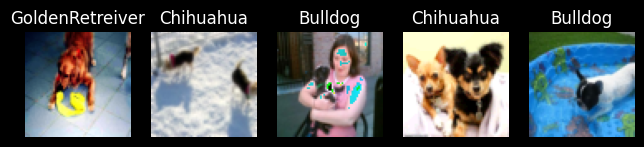

In [21]:
# Samples with data augmentation
view_dataloader_images(train_dataloader_dog_TrivialAugmentWide,
                       dog_class_names,
                       n=5)

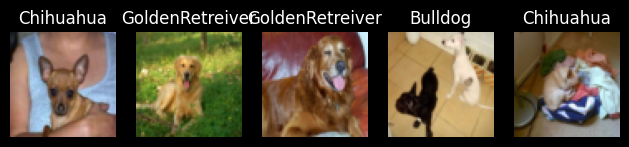

In [22]:
# Samples without data augmentation
view_dataloader_images(train_dataloader_dog,
                       dog_class_names,
                       n=5)

## Create models

In [23]:
from torchinfo import summary

In [24]:
HIDDEN_UNITS_1 = 10
HIDDEN_UNITS_2 = 10

### Dog model

In [26]:
import scripts.model_2
from old_scripts import model_builder

#model_dog = model_2.TinyVGGDropout(
model_dog = model_builder.TinyVGG(
                            input_shape=3,
                            output_shape=len(dog_class_names),
                            #hidden_units_1=HIDDEN_UNITS_1,
                            #hidden_units_2=HIDDEN_UNITS_2,
                            hidden_units=10
                            )

summary(model=model_dog,
        input_size=(1, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGGDropout (TinyVGGDropout)          [1, 3, 64, 64]       [1, 3]               --                   True
├─Sequential (conv_block_1)              [1, 3, 64, 64]       [1, 10, 30, 30]      --                   True
│    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 10, 62, 62]      280                  True
│    └─ReLU (1)                          [1, 10, 62, 62]      [1, 10, 62, 62]      --                   --
│    └─Dropout (2)                       [1, 10, 62, 62]      [1, 10, 62, 62]      --                   --
│    └─Conv2d (3)                        [1, 10, 62, 62]      [1, 10, 60, 60]      910                  True
│    └─ReLU (4)                          [1, 10, 60, 60]      [1, 10, 60, 60]      --                   --
│    └─Dropout (5)                       [1, 10, 60, 60]      [1, 10, 60, 60]      --                   --
│    └─MaxPool2d (6)  

### CIFAR model

In [27]:
from old_scripts import model_builder

model_cifar = model_builder.TinyVGG(input_shape=3,
                            output_shape=len(cifar_class_names),
                            #hidden_units_1=HIDDEN_UNITS_1,
                            #hidden_units_2=HIDDEN_UNITS_2,
                            hidden_units=10)

summary(model=model_cifar,
        input_size=(1, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [1, 3, 64, 64]       [1, 10]              --                   True
├─Sequential (conv_block_1)              [1, 3, 64, 64]       [1, 10, 30, 30]      --                   True
│    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 10, 62, 62]      280                  True
│    └─ReLU (1)                          [1, 10, 62, 62]      [1, 10, 62, 62]      --                   --
│    └─Conv2d (2)                        [1, 10, 62, 62]      [1, 10, 60, 60]      910                  True
│    └─ReLU (3)                          [1, 10, 60, 60]      [1, 10, 60, 60]      --                   --
│    └─MaxPool2d (4)                     [1, 10, 60, 60]      [1, 10, 30, 30]      --                   --
├─Sequential (conv_block_2)              [1, 10, 30, 30]      [1, 10, 13, 13]      --                   True
│    └─Conv2d (0)   

## Setup modelling experiments

In [28]:
# Create epoch list
num_epochs = [100]#[10, 20]

# Set learning rate
lr = 0.001

### Dog experiments

In [29]:
# Create models list
models = ["model_dog"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders_dog = {"no_aug": train_dataloader_dog,
                     "AutoAugment": train_dataloader_dog_AutoAugment,
                     "RandAugment": train_dataloader_dog_RandAugment,
                     "AugMix": train_dataloader_dog_AugMix,
                     "TrivialAugmentWide": train_dataloader_dog_TrivialAugmentWide}

In [30]:
%%time
from scripts.utils import save_model

# 1. Set the random seeds
hf.set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader_dog in train_dataloaders_dog.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 
      
        model_name = "model_dog"

         # 6. Create information print outs
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epochs}")  

        # 7. Select the model
        model = model_dog

        # 8. Create a new loss and optimizer for every model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        #optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

        # 9. Train target model with target dataloaders and track experiments
        train(model=model,
              train_dataloader=train_dataloader_dog,
              test_dataloader=test_dataloader_dog,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device=device,
              writer=create_writer(experiment_name=dataloader_name,
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs"))
        
        # 10. Save the model to file so we can get back the best model
        save_filepath = f"{experiment_number:04d}_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
        save_model(model=model,
                    target_dir="models",
                    model_name=save_filepath)
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: model_dog
[INFO] DataLoader: no_aug
[INFO] Number of epochs: 100
[INFO] Created SummaryWriter, saving to: runs/2024-01-10/no_aug/model_dog/100_epochs...


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0922 | train_acc: 1.0922 | test_loss: 1.0449 | test_acc: 0.4621
Epoch: 2 | train_loss: 1.0121 | train_acc: 1.0121 | test_loss: 0.9828 | test_acc: 0.4978
Epoch: 3 | train_loss: 0.9620 | train_acc: 0.9620 | test_loss: 0.9975 | test_acc: 0.4838
Epoch: 4 | train_loss: 0.9380 | train_acc: 0.9380 | test_loss: 0.9331 | test_acc: 0.5243
Epoch: 5 | train_loss: 0.9189 | train_acc: 0.9189 | test_loss: 0.9520 | test_acc: 0.5293
Epoch: 6 | train_loss: 0.9006 | train_acc: 0.9006 | test_loss: 0.9564 | test_acc: 0.5223
Epoch: 7 | train_loss: 0.8949 | train_acc: 0.8949 | test_loss: 0.8981 | test_acc: 0.5592
Epoch: 8 | train_loss: 0.8704 | train_acc: 0.8704 | test_loss: 0.9156 | test_acc: 0.5527
Epoch: 9 | train_loss: 0.8493 | train_acc: 0.8493 | test_loss: 0.9250 | test_acc: 0.5558
Epoch: 10 | train_loss: 0.8410 | train_acc: 0.8410 | test_loss: 1.0055 | test_acc: 0.5025
Epoch: 11 | train_loss: 0.8280 | train_acc: 0.8280 | test_loss: 0.9636 | test_acc: 0.5410
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7232 | train_acc: 3.7232 | test_loss: 3.1476 | test_acc: 0.4741
Epoch: 2 | train_loss: 1.6412 | train_acc: 1.6412 | test_loss: 1.8529 | test_acc: 0.4813
Epoch: 3 | train_loss: 1.2876 | train_acc: 1.2876 | test_loss: 1.2093 | test_acc: 0.4542
Epoch: 4 | train_loss: 1.1314 | train_acc: 1.1314 | test_loss: 1.1560 | test_acc: 0.4534
Epoch: 5 | train_loss: 1.1275 | train_acc: 1.1275 | test_loss: 1.1613 | test_acc: 0.4302
Epoch: 6 | train_loss: 1.1197 | train_acc: 1.1197 | test_loss: 1.1099 | test_acc: 0.4244
Epoch: 7 | train_loss: 1.0941 | train_acc: 1.0941 | test_loss: 1.0932 | test_acc: 0.4216
Epoch: 8 | train_loss: 1.0977 | train_acc: 1.0977 | test_loss: 1.0966 | test_acc: 0.3873
Epoch: 9 | train_loss: 1.0798 | train_acc: 1.0798 | test_loss: 1.0842 | test_acc: 0.4227
Epoch: 10 | train_loss: 1.0869 | train_acc: 1.0869 | test_loss: 1.0882 | test_acc: 0.4258
Epoch: 11 | train_loss: 1.0931 | train_acc: 1.0931 | test_loss: 1.0747 | test_acc: 0.4406
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8226 | train_acc: 0.8226 | test_loss: 1.0328 | test_acc: 0.5273
Epoch: 2 | train_loss: 0.8040 | train_acc: 0.8040 | test_loss: 1.0056 | test_acc: 0.5148
Epoch: 3 | train_loss: 0.8184 | train_acc: 0.8184 | test_loss: 1.0169 | test_acc: 0.5056
Epoch: 4 | train_loss: 0.7739 | train_acc: 0.7739 | test_loss: 1.0064 | test_acc: 0.5385
Epoch: 5 | train_loss: 0.8194 | train_acc: 0.8194 | test_loss: 1.0246 | test_acc: 0.5089
Epoch: 6 | train_loss: 0.7801 | train_acc: 0.7801 | test_loss: 1.0754 | test_acc: 0.5017
Epoch: 7 | train_loss: 0.7840 | train_acc: 0.7840 | test_loss: 0.9955 | test_acc: 0.5028
Epoch: 8 | train_loss: 0.7824 | train_acc: 0.7824 | test_loss: 1.1323 | test_acc: 0.5145
Epoch: 9 | train_loss: 0.7445 | train_acc: 0.7445 | test_loss: 1.0030 | test_acc: 0.5432
Epoch: 10 | train_loss: 0.7736 | train_acc: 0.7736 | test_loss: 1.0153 | test_acc: 0.5031
Epoch: 11 | train_loss: 0.7698 | train_acc: 0.7698 | test_loss: 1.0196 | test_acc: 0.5017
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4279 | train_acc: 0.4279 | test_loss: 1.2663 | test_acc: 0.5047
Epoch: 2 | train_loss: 0.3657 | train_acc: 0.3657 | test_loss: 1.4938 | test_acc: 0.5036
Epoch: 3 | train_loss: 0.3383 | train_acc: 0.3383 | test_loss: 1.4896 | test_acc: 0.5226
Epoch: 4 | train_loss: 0.3237 | train_acc: 0.3237 | test_loss: 1.6039 | test_acc: 0.5366
Epoch: 5 | train_loss: 0.3060 | train_acc: 0.3060 | test_loss: 1.6425 | test_acc: 0.5187
Epoch: 6 | train_loss: 0.2903 | train_acc: 0.2903 | test_loss: 1.7084 | test_acc: 0.4791
Epoch: 7 | train_loss: 0.2873 | train_acc: 0.2873 | test_loss: 1.7504 | test_acc: 0.4933
Epoch: 8 | train_loss: 0.2731 | train_acc: 0.2731 | test_loss: 1.7602 | test_acc: 0.4774
Epoch: 9 | train_loss: 0.2701 | train_acc: 0.2701 | test_loss: 1.7986 | test_acc: 0.4872
Epoch: 10 | train_loss: 0.2489 | train_acc: 0.2489 | test_loss: 2.0339 | test_acc: 0.5287
Epoch: 11 | train_loss: 0.2810 | train_acc: 0.2810 | test_loss: 1.9365 | test_acc: 0.4724
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0402 | train_acc: 1.0402 | test_loss: 1.7310 | test_acc: 0.4420
Epoch: 2 | train_loss: 0.8609 | train_acc: 0.8609 | test_loss: 1.4993 | test_acc: 0.4699
Epoch: 3 | train_loss: 0.7802 | train_acc: 0.7802 | test_loss: 1.2881 | test_acc: 0.4858
Epoch: 4 | train_loss: 0.7474 | train_acc: 0.7474 | test_loss: 1.3604 | test_acc: 0.4707
Epoch: 5 | train_loss: 0.7584 | train_acc: 0.7584 | test_loss: 1.3679 | test_acc: 0.4487
Epoch: 6 | train_loss: 0.6916 | train_acc: 0.6916 | test_loss: 1.3145 | test_acc: 0.4933
Epoch: 7 | train_loss: 0.7064 | train_acc: 0.7064 | test_loss: 1.4096 | test_acc: 0.4685
Epoch: 8 | train_loss: 0.7175 | train_acc: 0.7175 | test_loss: 1.2545 | test_acc: 0.4980
Epoch: 9 | train_loss: 0.7331 | train_acc: 0.7331 | test_loss: 1.2456 | test_acc: 0.4992
Epoch: 10 | train_loss: 0.7218 | train_acc: 0.7218 | test_loss: 1.1970 | test_acc: 0.4841
Epoch: 11 | train_loss: 0.7079 | train_acc: 0.7079 | test_loss: 1.2017 | test_acc: 0.4830
Epoch: 12 | train_l

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### CIFAR experiments

In [30]:
# Create models list
models = ["model_cifar"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders_cifar = {"no_aug": train_dataloader_cifar,
                     "AutoAugment": train_dataloader_cifar_AutoAugment,
                     "RandAugment": train_dataloader_cifar_RandAugment,
                     "AugMix": train_dataloader_cifar_AugMix,
                     "TrivialAugmentWide": train_dataloader_cifar_TrivialAugmentWide}

In [31]:
%%time
from scripts.utils import save_model

# 1. Set the random seeds
hf.set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader_cifar in train_dataloaders_cifar.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 
      
        model_name = "model_cifar"

        # 6. Create information print outs
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epochs}")

        # 7. Select the model
        model = model_cifar

        # 8. Create a new loss and optimizer for every model
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

        # 9. Train target model with target dataloaders and track experiments
        train(model=model,
              train_dataloader=train_dataloader_cifar,
              test_dataloader=test_dataloader_cifar,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device=device,
              writer=create_writer(experiment_name=dataloader_name,
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs"))
        
        # 10. Save the model to file so we can get back the best model
        save_filepath = f"{experiment_number:04d}_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
        save_model(model=model,
                    target_dir="models",
                    model_name=save_filepath)
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: model_cifar
[INFO] DataLoader: no_aug
[INFO] Number of epochs: 100
[INFO] Created SummaryWriter, saving to: runs/2024-01-10/no_aug/model_cifar/100_epochs...


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7408 | train_acc: 1.7408 | test_loss: 1.4499 | test_acc: 0.4839
Epoch: 2 | train_loss: 1.4062 | train_acc: 1.4062 | test_loss: 1.3462 | test_acc: 0.5180
Epoch: 3 | train_loss: 1.3196 | train_acc: 1.3196 | test_loss: 1.2823 | test_acc: 0.5472
Epoch: 4 | train_loss: 1.2539 | train_acc: 1.2539 | test_loss: 1.2674 | test_acc: 0.5466
Epoch: 5 | train_loss: 1.2060 | train_acc: 1.2060 | test_loss: 1.2182 | test_acc: 0.5706
Epoch: 6 | train_loss: 1.1688 | train_acc: 1.1688 | test_loss: 1.2000 | test_acc: 0.5710
Epoch: 7 | train_loss: 1.1374 | train_acc: 1.1374 | test_loss: 1.1724 | test_acc: 0.5870
Epoch: 8 | train_loss: 1.1173 | train_acc: 1.1173 | test_loss: 1.1527 | test_acc: 0.5969
Epoch: 9 | train_loss: 1.0897 | train_acc: 1.0897 | test_loss: 1.1619 | test_acc: 0.5902
Epoch: 10 | train_loss: 1.0670 | train_acc: 1.0670 | test_loss: 1.1431 | test_acc: 0.5987
Epoch: 11 | train_loss: 1.0517 | train_acc: 1.0517 | test_loss: 1.1274 | test_acc: 0.6018
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5218 | train_acc: 1.5218 | test_loss: 1.1360 | test_acc: 0.6055
Epoch: 2 | train_loss: 1.4002 | train_acc: 1.4002 | test_loss: 1.1525 | test_acc: 0.5997
Epoch: 3 | train_loss: 1.3663 | train_acc: 1.3663 | test_loss: 1.1257 | test_acc: 0.6062
Epoch: 4 | train_loss: 1.3524 | train_acc: 1.3524 | test_loss: 1.1040 | test_acc: 0.6173
Epoch: 5 | train_loss: 1.3333 | train_acc: 1.3333 | test_loss: 1.1287 | test_acc: 0.6105
Epoch: 6 | train_loss: 1.3237 | train_acc: 1.3237 | test_loss: 1.1111 | test_acc: 0.6118
Epoch: 7 | train_loss: 1.3125 | train_acc: 1.3125 | test_loss: 1.0933 | test_acc: 0.6236
Epoch: 8 | train_loss: 1.3080 | train_acc: 1.3080 | test_loss: 1.0880 | test_acc: 0.6243
Epoch: 9 | train_loss: 1.2979 | train_acc: 1.2979 | test_loss: 1.1286 | test_acc: 0.6134
Epoch: 10 | train_loss: 1.2969 | train_acc: 1.2969 | test_loss: 1.0865 | test_acc: 0.6202
Epoch: 11 | train_loss: 1.2928 | train_acc: 1.2928 | test_loss: 1.0793 | test_acc: 0.6268
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1605 | train_acc: 1.1605 | test_loss: 1.0051 | test_acc: 0.6494
Epoch: 2 | train_loss: 1.1412 | train_acc: 1.1412 | test_loss: 1.0014 | test_acc: 0.6507
Epoch: 3 | train_loss: 1.1363 | train_acc: 1.1363 | test_loss: 0.9999 | test_acc: 0.6446
Epoch: 4 | train_loss: 1.1253 | train_acc: 1.1253 | test_loss: 0.9936 | test_acc: 0.6538
Epoch: 5 | train_loss: 1.1219 | train_acc: 1.1219 | test_loss: 1.0036 | test_acc: 0.6484
Epoch: 6 | train_loss: 1.1128 | train_acc: 1.1128 | test_loss: 0.9637 | test_acc: 0.6609
Epoch: 7 | train_loss: 1.1139 | train_acc: 1.1139 | test_loss: 0.9928 | test_acc: 0.6488
Epoch: 8 | train_loss: 1.1100 | train_acc: 1.1100 | test_loss: 0.9879 | test_acc: 0.6512
Epoch: 9 | train_loss: 1.1079 | train_acc: 1.1079 | test_loss: 0.9847 | test_acc: 0.6575
Epoch: 10 | train_loss: 1.1031 | train_acc: 1.1031 | test_loss: 0.9849 | test_acc: 0.6551
Epoch: 11 | train_loss: 1.1040 | train_acc: 1.1040 | test_loss: 0.9621 | test_acc: 0.6641
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9202 | train_acc: 0.9202 | test_loss: 0.9333 | test_acc: 0.6753
Epoch: 2 | train_loss: 0.9077 | train_acc: 0.9077 | test_loss: 0.9480 | test_acc: 0.6708
Epoch: 3 | train_loss: 0.8963 | train_acc: 0.8963 | test_loss: 0.9457 | test_acc: 0.6700
Epoch: 4 | train_loss: 0.8977 | train_acc: 0.8977 | test_loss: 0.9604 | test_acc: 0.6690
Epoch: 5 | train_loss: 0.8916 | train_acc: 0.8916 | test_loss: 0.9468 | test_acc: 0.6751
Epoch: 6 | train_loss: 0.8876 | train_acc: 0.8876 | test_loss: 0.9435 | test_acc: 0.6761
Epoch: 7 | train_loss: 0.8870 | train_acc: 0.8870 | test_loss: 0.9656 | test_acc: 0.6712
Epoch: 8 | train_loss: 0.8794 | train_acc: 0.8794 | test_loss: 0.9708 | test_acc: 0.6648
Epoch: 9 | train_loss: 0.8814 | train_acc: 0.8814 | test_loss: 0.9770 | test_acc: 0.6639
Epoch: 10 | train_loss: 0.8722 | train_acc: 0.8722 | test_loss: 0.9991 | test_acc: 0.6598
Epoch: 11 | train_loss: 0.8725 | train_acc: 0.8725 | test_loss: 0.9663 | test_acc: 0.6724
Epoch: 12 | train_l

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3561 | train_acc: 1.3561 | test_loss: 0.9918 | test_acc: 0.6550
Epoch: 2 | train_loss: 1.2939 | train_acc: 1.2939 | test_loss: 0.9865 | test_acc: 0.6576
Epoch: 3 | train_loss: 1.2694 | train_acc: 1.2694 | test_loss: 0.9752 | test_acc: 0.6597
Epoch: 4 | train_loss: 1.2634 | train_acc: 1.2634 | test_loss: 0.9809 | test_acc: 0.6575
Epoch: 5 | train_loss: 1.2643 | train_acc: 1.2643 | test_loss: 0.9782 | test_acc: 0.6569
Epoch: 6 | train_loss: 1.2588 | train_acc: 1.2588 | test_loss: 1.0120 | test_acc: 0.6498
Epoch: 7 | train_loss: 1.2605 | train_acc: 1.2605 | test_loss: 0.9715 | test_acc: 0.6645
Epoch: 8 | train_loss: 1.2458 | train_acc: 1.2458 | test_loss: 0.9702 | test_acc: 0.6605
Epoch: 9 | train_loss: 1.2385 | train_acc: 1.2385 | test_loss: 0.9980 | test_acc: 0.6507
Epoch: 10 | train_loss: 1.2416 | train_acc: 1.2416 | test_loss: 0.9928 | test_acc: 0.6543
Epoch: 11 | train_loss: 1.2340 | train_acc: 1.2340 | test_loss: 0.9866 | test_acc: 0.6567
Epoch: 12 | train_l

In [32]:
%load_ext tensorboard
%tensorboard --logdir runs